In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator, AutoMinorLocator # custom tick locators for plots
from matplotlib.backends.backend_pdf import PdfPages
#%matplotlib inline

In [ ]:
#Data and analysis by Joe Piechura, using SPP (https://www.nature.com/articles/nbt.1508) for ChIP-seq peak finding
#and principles from Peak-Seq (https://www.nature.com/articles/nbt.1518) and DE-seq (https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-10-r106)
#to normalize ChIP-seq and RNA-seq data, with implementations of these algorithms in Matlab created by Joe Markson

#The cyanobacterium Synechococcus elongatus PCC 7942 has a circadian clock that controls gene expression. The clock causes 
#a transcription factor called RpaA to bind DNA in a rhythmic fashion over the course of the day to turn on nearby genes
#and indirectly activate others (Markson and Piechura, et al 2013, http://www.cell.com/cell/fulltext/S0092-8674(13)01418-9). 

#Another protein called RpaB changes gene expression when cyanobacteria are suddenly exposed to high amounts of light.

#I studied how RpaA and RpaB regulate the expression of genes to understand how information from a circadian clock
#encoded in RpaA activity might interact with information about changes in light, encoded in RpaB activity.
#The data presented here are from initial experiments in this project, and the full work has been published
#as Piechura and Amarnath, et al 2017 - https://elifesciences.org/articles/32032

In [2]:
##Define RpaA ChIP file names and explain data

#Immunoprecipitation was used to isolate DNA pieces from the cyanobacteria Synechococcus elongatus PCC7942
#bound to the transcription factor RpaA, and these DNA pieces were sequenced on an Illumina HiSeq
#Sequencing data were aligned to the genome and smoothed and normalized in Matlab 
#using an implementation of the Peak-seq algorithm to produce vectors of normalized read counts per base pair

#Below are ChIP files of normalized read counts per base pair in csv format
#from cyanobacteria exposed to high light. 'A' indicates that the experiment was for RpaA ChIP
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
#before exposure to high light
#The number after the second subscript indicates the number of minutes the bacteria were grown in high light
A_24_0_file = 'RpaA ChIP/A_24_0'
A_24_5_file = 'RpaA ChIP/A_24_5'
A_24_15_file = 'RpaA ChIP/A_24_15'
A_32_0_file = 'RpaA ChIP/A_32_0'
A_32_5_file = 'RpaA ChIP/A_32_5'
A_32_15_file = 'RpaA ChIP/A_32_15'
A_32_30_file = 'RpaA ChIP/A_32_30'

#This is a mock immunopreciptation experiment where a pool of the samples from the high light experiment were 
#immunoprecipitated with a generic Igg antibody, providing the background of the experiment
Mock_hl_file = 'Mock_hl'

#Below are ChIP files from cyanobacteria grown continuously in constant 'circadian' conditions. 
#'A' indicates that the experiment was for RpaA ChIP
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
A_24_file = 'RpaA ChIP/A_24'
A_28_file = 'RpaA ChIP/A_28'
A_32_file = 'RpaA ChIP/A_32'
A_36_file = 'RpaA ChIP/A_36'
A_40_file = 'RpaA ChIP/A_40'
A_44_file = 'RpaA ChIP/A_44'
A_48_file = 'RpaA ChIP/A_48'

#This is a mock immunopreciptation experiment where a pool of the samples from the circadian experiment were 
#immunoprecipitated with a generic Igg antibody, providing the background of the experiment
Mock_circ_file = 'Mock_circ'

#peak lists are filtered output from the peakfinding algorithm SPP
#'hl' are the peaks discovered by SPP for samples from the High Light experiment described above, manually filtered
#to include only peaks which were enriched at least 3 fold at one timepoint in the experiment
#'circ' are the peaks discovered by SPP for samples from the Circadian experiment described above, manually filtered
#to include only peaks which were enriched at least 3 fold at one timepoint in the experiment
A_hl_peaks = 'RpaA ChIP/A_peaks_3fold_hl'
A_circadian_peaks = 'RpaA ChIP/A_peaks_3fold_circ'

#For each peak in the peaklists, I calculated an enrichment value at the position of center of the peak by dividing
#the normalizaed read counts at the center position in a specific timepoint by the counts at the same position in
#the appropriate mock experiment. This analysis was done previously in Matlab and exported to a csv.
#Column identities for 'hl' experiment are '24 0','24 5','24 15','32 0','32 5','32 15','32 30'
#Column identities for 'circ' experiment are '24','28','32','36','40','44','48'
A_hl_enrich = 'RpaA ChIP/enrich_a_3fold_hl'
A_circadian_enrich = 'RpaA ChIP/enrich_a_3fold_circ'

In [3]:
##Upload RpaA ChIP data

#load chip data
A_24_0 = pd.read_csv(A_24_0_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
A_32_0 = pd.read_csv(A_32_0_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
A_24_15 = pd.read_csv(A_24_15_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
A_32_15 = pd.read_csv(A_32_15_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
A_28 = pd.read_csv(A_28_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
A_36 = pd.read_csv(A_36_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
Mock_hl = pd.read_csv(Mock_hl_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
Mock_circ = pd.read_csv(Mock_circ_file,names=['xsets'],dtype={'user_id': int},low_memory=False)

#load peak lists
A_peaks_3fold_hl = pd.read_csv(A_hl_peaks,usecols=np.arange(0,2),skiprows=np.concatenate((np.arange(2,11216,3),np.arange(3,11216,3))))
A_peaks_3fold_circ = pd.read_csv(A_circadian_peaks,usecols=np.arange(0,2),skiprows=np.concatenate((np.arange(2,11216,3),np.arange(3,11216,3))))
A_peaks_3fold_hl['peak number'] = range(1, len(A_peaks_3fold_hl) + 1)
A_peaks_3fold_circ['peak number'] = range(1, len(A_peaks_3fold_circ) + 1)

#load enrichment values for peaks
enrich_a_3fold_hl = pd.read_csv(A_hl_enrich,names=['24 0','24 5','24 15','32 0','32 5','32 15','32 30'])
enrich_a_3fold_circ = pd.read_csv(A_circadian_enrich,names=['24','28','32','36','40','44','48'])
enrich_a_hl_vals_24 = {}
enrich_a_hl_vals_32 = {}
for index, row in enrich_a_3fold_hl.iterrows():
    enrich_a_hl_vals_24['A, ' + str(index+1)] = pd.Series([row['24 0'],row['24 5'],row['24 15']],index=[0,5,15])
    enrich_a_hl_vals_32['A, ' + str(index+1)] = pd.Series([row['32 0'],row['32 5'],row['32 15'],row['32 30']],index=[0,5,15,30])
enrich_a_circ_vals = {}
for index, row in enrich_a_3fold_circ.iterrows():
    enrich_a_circ_vals['A, ' + str(index+1)] = pd.Series([row['24'],row['28'],row['32'],row['36'],row['40'],row['44'],row['48']],index=[24,28,32,36,40,44,48])
    
a_hl_vals_24_df = pd.DataFrame(enrich_a_hl_vals_24)
a_hl_vals_32_df = pd.DataFrame(enrich_a_hl_vals_32)
a_circ_vals_df = pd.DataFrame(enrich_a_circ_vals)


In [4]:
##Define RpaB ChIP file names and explain data

#Immunoprecipitation was used to isolate DNA pieces from the cyanobacteria Synechococcus elongatus PCC7942
#bound to the transcription factor RpaB, and these DNA pieces were sequenced on an Illumina HiSeq
#Sequencing data were aligned to the genome and smoothed and normalized in Matlab 
#using an implementation of the Peak-seq algorithm to produce vectors of normalized read counts per base pair

#Below are ChIP files of normalized read counts per base pair in csv format
#from cyanobacteria exposed to high light. 'B' indicates that the experiment was for RpaB ChIP
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
#before exposure to high light
#The number after the second subscript indicates the number of minutes the bacteria were grown in high light
B_24_0_file = 'RpaB ChIP/B_24_0'
B_24_5_file = 'RpaB ChIP/B_24_5'
B_24_15_file = 'RpaB ChIP/B_24_15'
B_24_30_file = 'RpaB ChIP/B_24_30'
B_32_0_file = 'RpaB ChIP/B_32_0'
B_32_5_file = 'RpaB ChIP/B_32_5'
B_32_15_file = 'RpaB ChIP/B_32_15'
B_32_30_file = 'RpaB ChIP/B_32_30'

#Below are ChIP files from cyanobacteria grown continuously in constant 'circadian' conditions. 
#'B' indicates that the experiment was for RpaB ChIP
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
B_28_file = 'RpaB ChIP/B_28'
B_32_file = 'RpaB ChIP/B_32'
B_36_file = 'RpaB ChIP/B_36'
B_40_file = 'RpaB ChIP/B_40'
B_48_file = 'RpaB ChIP/B_48'

#peak lists are filtered output from the peakfinding algorithm SPP
#'hl' are the peaks discovered by SPP for samples from the High Light experiment described above, manually filtered
#to include only peaks which were enriched at least 3 fold at one timepoint in the experiment
#'circ' are the peaks discovered by SPP for samples from the Circadian experiment described above, manually filtered
#to include only peaks which were enriched at least 3 fold at one timepoint in the experiment
B_hl_peaks = 'RpaB ChIP/B_peaks_3fold_hl'
B_circadian_peaks = 'RpaB ChIP/B_peaks_3fold_circ'

#For each peak in the peaklists, I calculated an enrichment value at the position of center of the peak by dividing
#the normalizaed read counts at the center position in a specific timepoint by the counts at the same position in
#the appropriate mock experiment. This analysis was done previously in Matlab and exported to a csv.
#Column identities for 'hl' experiment are '24 0','24 5','24 15','24 30',32 0','32 5','32 15','32 30'
#Column identities for 'circ' experiment are '28','32','36','40','48'
B_hl_enrich = 'RpaB ChIP/enrich_b_3fold_hl'
B_circadian_enrich = 'RpaB ChIP/enrich_b_3fold_circ'

In [5]:
##Upload RpaB ChIP data

#load chip data
B_24_0 = pd.read_csv(B_24_0_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
B_32_0 = pd.read_csv(B_32_0_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
B_24_15 = pd.read_csv(B_24_15_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
B_32_15 = pd.read_csv(B_32_15_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
B_28 = pd.read_csv(B_28_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
B_36 = pd.read_csv(B_36_file,names=['xsets'],dtype={'user_id': int},low_memory=False)


#load peak lists
B_peaks_3fold_hl = pd.read_csv(B_hl_peaks,usecols=np.arange(0,2),skiprows=np.concatenate((np.arange(2,11216,3),np.arange(3,11216,3))))
B_peaks_3fold_circ = pd.read_csv(B_circadian_peaks,usecols=np.arange(0,2),skiprows=np.concatenate((np.arange(2,11216,3),np.arange(3,11216,3))))
B_peaks_3fold_hl['peak number'] = range(1, len(B_peaks_3fold_hl) + 1)
B_peaks_3fold_circ['peak number'] = range(1, len(B_peaks_3fold_circ) + 1)
    
#load enrichment values for peaks
enrich_b_3fold_hl = pd.read_csv(B_hl_enrich,names=['24 0','24 5','24 15','24 30','32 0','32 5','32 15','32 30'])
enrich_b_3fold_circ = pd.read_csv(B_circadian_enrich,names=['28','32','36','40','48'])
enrich_b_hl_vals_24 = {}
enrich_b_hl_vals_32 = {}
for index, row in enrich_b_3fold_hl.iterrows():
    enrich_b_hl_vals_24['B, ' + str(index+1)] = pd.Series([row['24 0'],row['24 5'],row['24 15'],row['24 30']],index=[0,5,15,30])
    enrich_b_hl_vals_32['B, ' + str(index+1)] = pd.Series([row['32 0'],row['32 5'],row['32 15'],row['32 30']],index=[0,5,15,30])
enrich_b_circ_vals = {}
for index, row in enrich_b_3fold_circ.iterrows():
    enrich_b_circ_vals['B, ' + str(index+1)] = pd.Series([row['28'],row['32'],row['36'],row['40'],row['48']],index=[28,32,36,40,48])
    
b_hl_vals_24_df = pd.DataFrame(enrich_b_hl_vals_24)
b_hl_vals_32_df = pd.DataFrame(enrich_b_hl_vals_32)
b_circ_vals_df = pd.DataFrame(enrich_b_circ_vals)

In [6]:
##Define gene expression files and explain data

#below is a csv file which contains information on all the genes and annotated non-coding RNAs (from Vijayan, V et al Genome Biology 2011)
#for Synechococcus elongatus PCC7942. Most notable are definitions of the start and stop positions for the gene or ncRNA, and the strand upon
#which the gene resides. 
gene_info_file = 'RNAseq/genes_ncRNAs.csv'

#Below are RNAseq files of read counts per base pair, separated by the strand to which the reads align, in csv format
#from cyanobacteria exposed to high light. RNA was isolated from bacteria flash frozen at specific time points
#And RNAsequencing libraries were prepared from this RNA as described in Ingolia, NT et al 2009 to capture small RNAs
#'R' indicates that these are RNAseq data
#'plus' or 'minus' indicates that the strand of the genome to which reads aligned
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
#before exposure to high light
#The number after the second subscript indicates the number of minutes the bacteria were grown in high light
#These data are not normalized so they only serve to qualitatively display how RNA reads map to the genome and how
#these shapes might change over time

R_24_0_plus_file = 'RNAseq/R_24_0_plus'
R_24_0_minus_file = 'RNAseq/R_24_0_minus'
R_24_5_plus_file = 'RNAseq/R_24_5_plus'
R_24_5_minus_file = 'RNAseq/R_24_5_minus'
R_24_15_plus_file = 'RNAseq/R_24_15_plus'
R_24_15_minus_file = 'RNAseq/R_24_15_minus'
R_24_30_plus_file = 'RNAseq/R_24_30_plus'
R_24_30_minus_file = 'RNAseq/R_24_30_minus'

R_32_0_plus_file = 'RNAseq/R_32_0_plus'
R_32_0_minus_file = 'RNAseq/R_32_0_minus'
R_32_5_plus_file = 'RNAseq/R_32_5_plus'
R_32_5_minus_file = 'RNAseq/R_32_5_minus'
R_32_15_plus_file = 'RNAseq/R_32_15_plus'
R_32_15_minus_file = 'RNAseq/R_32_15_minus'
R_32_30_plus_file = 'RNAseq/R_32_30_plus'
R_32_30_minus_file = 'RNAseq/R_32_30_minus'

#Below are RNAseq files from cyanobacteria grown continuously in constant 'circadian' conditions. 
#'R' indicates that these are RNAseq files
#'plus' or 'minus' indicates that the strand of the genome to which reads aligned
#The number after the first subscript indicates the number of hours the bacteria were grown in constant light 
R_28_plus_file = 'RNAseq/R_28_plus'
R_28_minus_file = 'RNAseq/R_28_minus'
R_32_plus_file = 'RNAseq/R_32_plus'
R_32_minus_file = 'RNAseq/R_32_minus'
R_36_plus_file = 'RNAseq/R_36_plus'
R_36_minus_file = 'RNAseq/R_36_minus'
R_40_plus_file = 'RNAseq/R_40_plus'
R_40_minus_file = 'RNAseq/R_40_minus'
R_44_plus_file = 'RNAseq/R_44_plus'
R_44_minus_file = 'RNAseq/R_44_minus'
R_48_plus_file = 'RNAseq/R_48_plus'
R_48_minus_file = 'RNAseq/R_48_minus'


#For each gene or ncRNA in the genes_ncRNAs list, I calculated an expression value by counting the number of reads occuring on the 
#appropriate strand between the start and stop positions of the gene or ncRNA. These data were normalized with median normalization
#as described in Anders and Huber 2010, and these normalized values were divided by the length of the gene or ncRNA
#This analysis was done previously in Matlab and exported to a csv.
#Column identities are '24 0','24 5','24 15','24 30','32 0','32 5','32 15','32 30','24','28','32','36','40','44','48'
gene_expr_file = 'RNAseq/expr_l_norm'

In [7]:
##Upload RNAseq data

#Load RNAseq data
R_28_plus = pd.read_csv(R_28_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_28_minus = pd.read_csv(R_28_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_36_plus = pd.read_csv(R_36_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_36_minus = pd.read_csv(R_36_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)

R_24_0_plus = pd.read_csv(R_24_0_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_24_0_minus = pd.read_csv(R_24_0_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_24_15_plus = pd.read_csv(R_24_15_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_24_15_minus = pd.read_csv(R_24_15_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)

R_32_0_plus = pd.read_csv(R_32_0_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_32_0_minus = pd.read_csv(R_32_0_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_32_15_plus = pd.read_csv(R_32_15_plus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)
R_32_15_minus = pd.read_csv(R_32_15_minus_file,names=['xsets'],dtype={'user_id': int},low_memory=False)


#Load gene and ncRNA information
global genes_ncRNAs
genes_ncRNAs = pd.read_csv(gene_info_file,usecols=np.arange(0,24),skiprows=np.concatenate((np.arange(2,11216,3),np.arange(3,11216,3))))

#Load gene expression data
expr_l_norm = pd.read_csv(gene_expr_file,names=['24 0','24 5','24 15','24 30','32 0','32 5','32 15','32 30','24','28','32','36','40','44','48'])
expr_circ_vals = {}
expr_hl_vals_24 = {}
expr_hl_vals_32 = {}
for index, row in expr_l_norm.iterrows():
    expr_circ_vals[index+1] = pd.Series([row['24'],row['28'],row['32'],row['36'],row['40'],row['44'],row['48']],index=[24,28,32,36,40,44,48])
    expr_hl_vals_24[index+1] = pd.Series([row['24 0'],row['24 5'],row['24 15'],row['24 30']],index=[0,5,15,30])
    expr_hl_vals_32[index+1] = pd.Series([row['32 0'],row['32 5'],row['32 15'],row['32 30']],index=[0,5,15,30])
    
expr_hl_vals_24_df = pd.DataFrame(expr_hl_vals_24)
expr_hl_vals_32_df = pd.DataFrame(expr_hl_vals_32)
expr_circ_vals_df = pd.DataFrame(expr_circ_vals)

In [8]:
#functions for plotting the data
def gene_window(gene_name):
    global gene
    global window_start
    global window_end
    global A_hl_sub
    global B_hl_sub
    global A_circ_sub
    global B_circ_sub
    global A_hl_sub_vals_24
    global A_hl_sub_vals_32
    global B_hl_sub_vals_24 
    global B_hl_sub_vals_32
    global A_circ_sub_vals
    global B_circ_sub_vals
    global A_hl_sub_24_n
    global A_hl_sub_32_n
    global B_hl_sub_24_n
    global B_hl_sub_32_n
    global A_circ_sub_n
    global B_circ_sub_n
    global name
        

    gene = genes_ncRNAs.name[genes_ncRNAs.name == gene_name].index[0]
    window_start = genes_ncRNAs.loc[gene,'start'] - 500
    window_end = genes_ncRNAs.loc[gene,'start'] + 500

    A_hl_sub = {}
    A_circ_sub = {}
    B_hl_sub = {}
    B_circ_sub ={}

    A_hl_sub = A_peaks_3fold_hl[(A_peaks_3fold_hl['start'] > window_start) & (A_peaks_3fold_hl['start'] < window_end)]
    A_circ_sub = A_peaks_3fold_circ[(A_peaks_3fold_circ['start'] > window_start) & (A_peaks_3fold_circ['start'] < window_end)]
    B_hl_sub = B_peaks_3fold_hl[(B_peaks_3fold_hl['start'] > window_start) & (B_peaks_3fold_hl['start'] < window_end)]
    B_circ_sub = B_peaks_3fold_circ[(B_peaks_3fold_circ['start'] > window_start) & (B_peaks_3fold_circ['start'] < window_end)]

    A_hl_sub_24_n = []
    for index, row in A_hl_sub.iterrows():
        A_hl_sub_24_n.append('A, ' + str(row['peak number']))
    
    A_hl_sub_32_n = []
    for index, row in A_hl_sub.iterrows():
        A_hl_sub_32_n.append('A, ' + str(row['peak number']))
    
    B_hl_sub_24_n = []
    for index, row in B_hl_sub.iterrows():
        B_hl_sub_24_n.append('B, ' + str(row['peak number']))
    
    B_hl_sub_32_n = []
    for index, row in B_hl_sub.iterrows():
        B_hl_sub_32_n.append('B, ' + str(row['peak number']))
    
    A_circ_sub_n = []
    for index, row in A_circ_sub.iterrows():
        A_circ_sub_n.append('A, ' + str(row['peak number']))

    B_circ_sub_n = []
    for index, row in B_circ_sub.iterrows():
        B_circ_sub_n.append('B, ' + str(row['peak number']))
                      
    A_hl_sub_vals_24 = {}
    A_hl_sub_vals_32 = {}
    B_hl_sub_vals_24 = {}
    B_hl_sub_vals_32 = {}
    A_circ_sub_vals = {}
    B_circ_sub_vals = {}

    A_hl_sub_vals_24 = a_hl_vals_24_df.loc[:,A_hl_sub_24_n]
    A_hl_sub_vals_32 = a_hl_vals_32_df.loc[:,A_hl_sub_32_n]
    B_hl_sub_vals_24 = b_hl_vals_24_df.loc[:,B_hl_sub_24_n]
    B_hl_sub_vals_32 = b_hl_vals_32_df.loc[:,B_hl_sub_32_n]
    A_circ_sub_vals = a_circ_vals_df.loc[:,A_circ_sub_n]
    B_circ_sub_vals = b_circ_vals_df.loc[:,B_circ_sub_n]
    
    name = genes_ncRNAs.loc[gene,'name']



def circ_rna_counts():
    global fig_circ_rna_counts
    fig_circ_rna_counts = plt.figure()
    axis = np.arange(window_start,window_end)
    ax = plt.subplot(111)
    ax.plot(axis,A_28.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson', linestyle = '--',label = 'A ZT 28')
    ax.plot(axis,B_28.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B ZT 28')
    ax.plot(axis,A_36.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson', label = 'A ZT 36')
    ax.plot(axis,B_36.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B ZT 36')
  
    ax.plot(axis,Mock_circ.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')
    temp = ax.legend(bbox_to_anchor=(1.1,0.8,0.4,0.2) )

    A_circ_sub_arrays = []
    ymin, ymax1 = ax.get_ylim()
    plt.ylim(ymax=ymax1*1.25)
    ymin, ymax2 = ax.get_ylim()
    for index, row in A_circ_sub.iterrows():
        ax.axvspan(A_circ_sub.loc[index,'start'], A_circ_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='crimson', alpha=.4)
        ax.annotate(A_circ_sub.loc[index,'peak number'], xy=(A_circ_sub.loc[index,'start'], ymax2*.92))

    for index, row in B_circ_sub.iterrows():
        ax.axvspan(B_circ_sub.loc[index,'start'], B_circ_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='mediumblue', alpha=.4)
        ax.annotate(B_circ_sub.loc[index,'peak number'], xy=(B_circ_sub.loc[index,'start'], ymax2*.95))
        

    ax2 = ax.twinx()

    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .8)
        ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(genes_ncRNAs.loc[gene,'start'], ymax2*.95))
        ax2.plot(axis,R_36_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA ZT 36',color='darkgray')
        ax2.plot(axis,R_28_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA ZT 28',color='lightsteelblue')
    else: 
        ax.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .8)
        ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(window_start,ymax2*.95))
        ax2.plot(axis,R_36_minus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA ZT 36',color='darkgray')
        ax2.plot(axis,R_28_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA ZT 28',color='lightsteelblue')
        
    ymin, ymax1 = ax2.get_ylim()
    plt.ylim(ymax=ymax1*1.25)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.set_ylabel('Normalized ChiP-seq\nread counts',ha='center',labelpad=20)
    ax.set_xlabel('Chromosomal position')
    ax2.set_ylabel('RNAseq read counts')
    ax.legend(lines + lines2,labels+labels2,bbox_to_anchor=(1.1,0.8,0.4,0.2))
    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax.xaxis.set( major_locator = MaxNLocator(5) )
    ax2.yaxis.set( major_locator = MaxNLocator(4))
    plt.tight_layout()
    plt.title('Constant Conditions, ' + name)
    plt.show()

    fig_circ_rna_counts.clf()

def circ_counts():
    global fig_circ_rna_counts
    fig_circ_rna_counts = plt.figure()
    axis = np.arange(window_start,window_end)
    ax = plt.subplot(111)
    ax.plot(axis,A_28.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson', linestyle = '--',label = 'A ZT 28')
    ax.plot(axis,B_28.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B ZT 28')
    ax.plot(axis,A_36.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson', label = 'A ZT 36')
    ax.plot(axis,B_36.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B ZT 36')
  
    ax.plot(axis,Mock_circ.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')
    temp = ax.legend(bbox_to_anchor=(1.1,0.8,0.4,0.2) )

    A_circ_sub_arrays = []
    ymin, ymax1 = ax.get_ylim()
    plt.ylim(ymax=ymax1*1.25)
    ymin, ymax2 = ax.get_ylim()
    for index, row in A_circ_sub.iterrows():
        ax.axvspan(A_circ_sub.loc[index,'start'], A_circ_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='crimson', alpha=.4)
        ax.annotate(A_circ_sub.loc[index,'peak number'], xy=(A_circ_sub.loc[index,'start'], ymax2*.92))

    for index, row in B_circ_sub.iterrows():
        ax.axvspan(B_circ_sub.loc[index,'start'], B_circ_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='mediumblue', alpha=.4)
        ax.annotate(B_circ_sub.loc[index,'peak number'], xy=(B_circ_sub.loc[index,'start'], ymax2*.95))
        



    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .8)
        ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(genes_ncRNAs.loc[gene,'start'], ymax2*.95))
    else: 
        ax.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .8)
        ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(window_start,ymax2*.95))

    lines, labels = ax.get_legend_handles_labels()
    ax.set_ylabel('Normalized ChiP-seq\nread counts',ha='center',labelpad=20)
    ax.set_xlabel('Chromosomal position')

    ax.legend(bbox_to_anchor=(1,0.8,0.4,0.2))
    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax.xaxis.set( major_locator = MaxNLocator(5) )

    plt.tight_layout()
    plt.title('Constant Conditions, ' + name)
    plt.show()
    fig_circ_rna_counts.clf()
    
    

def circ_plot():
    marker_styles = {1 : 'o', 2 : 's', 3 : 'v', 4 : 'D'}
    global fig_circ
    fig_circ = plt.figure()
    ax = plt.subplot(111)
    count = 0
    for col in A_circ_sub_vals.columns:
        count = count + 1
        ax.plot([24,28,32,36,40,44,48],A_circ_sub_vals.loc[:,col],label = col, color = 'crimson', marker = marker_styles[count],linewidth = 2,  markersize = 7)

    ax2 = ax.twinx()
    count = 0
    for col in B_circ_sub_vals.columns:
        count = count + 1
        ax2.plot([28,32,36,40,48],B_circ_sub_vals.loc[:,col],label = col, color = 'mediumblue', marker = marker_styles[count],linewidth = 2, markersize = 7)

    ax.set_xlim( left = 20, right = 55 )
    ax.set_ylim( bottom = 0)
    ax2.set_ylim( bottom = 0)
    ax.set_xlabel("Time in continuous light (hours)")
    ax.set_ylabel("RpaA enrichment over mock")
    ax2.set_ylabel("RpaB enrichment over mock")
    ax2.set_xlim( left = 20, right = 55)


    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))

    ax3.spines["right"].set_visible(True)
    ax3.set_xlim( left= 20, right = 55)
    ax3.plot([24,28,32,36,40,44,48],expr_circ_vals_df.loc[:,gene+1],label = 'Expression', color = 'black', linewidth = 2, marker = 'D', markersize = 7)
    ax3.set_ylim( bottom = 0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3,bbox_to_anchor=(1.5,0.8,0.4,0.2))
    ax3.set_ylabel('Median and length\nnormalized gene expression',ha='center',labelpad=20)

    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax2.yaxis.set( major_locator = MaxNLocator(4) )
    ax3.yaxis.set( major_locator = MaxNLocator(4) )
    plt.title('Constant Conditions, ' + name)
    plt.show()
def high_light_rna_counts():
    global fig_hl_rna_counts
    fig_hl_rna_counts = plt.figure(figsize=(8, 6))
    axis = np.arange(window_start,window_end)
    ax = plt.subplot(211)
    ax.plot(axis,A_24_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',label = 'A 24, 0')
    ax.plot(axis,A_24_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',linestyle = '--', label = 'A 24, 15')
    ax.plot(axis,B_24_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B 24, 0')
    ax.plot(axis,B_24_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B 24, 15')
    ax.plot(axis,Mock_hl.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')


    axb = ax.twinx()
    
    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
        
        axb.plot(axis,R_24_0_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 24 0',color='darkgray')
        axb.plot(axis,R_24_15_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 24 15',color='lightsteelblue')
    else: 
        ax.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
        
        axb.plot(axis,R_24_0_minus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 24 0',color='darkgray')
        axb.plot(axis,R_24_15_minus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 24 15',color='lightsteelblue')
    xticklabels = ax.get_xticklabels()
    lines, labels = ax.get_legend_handles_labels()
    linesb, labelsb = axb.get_legend_handles_labels()
    #setp(xticklabels, visible=False)
    ax.legend(lines+linesb,labels+labelsb,bbox_to_anchor=(.9,0.8,0.4,0.2) )
    for index, row in A_hl_sub.iterrows():
        ax.axvspan(A_hl_sub.loc[index,'start'], A_hl_sub.loc[index,'end'], ymin=.9, ymax=1, facecolor='crimson', alpha=.4)
        

    for index, row in B_hl_sub.iterrows():
        ax.axvspan(B_hl_sub.loc[index,'start'], B_hl_sub.loc[index,'end'], ymin=.9, ymax=1, facecolor='mediumblue', alpha=0.4)
        
    plt.title('24 hours in constant light, ' + name)

    ax2 = plt.subplot(212,sharex = ax, sharey = ax)

    ax2.plot(axis,A_32_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',label = 'A 32, 0 min')
    ax2.plot(axis,A_32_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',linestyle = '--', label = 'A 32, 15 min')
    ax2.plot(axis,B_32_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B 32, 0 min')
    ax2.plot(axis,B_32_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B 32, 15 min')
    ax2.plot(axis,Mock_hl.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')

    ax2b = ax2.twinx()
    ymin, ymax1 = ax2.get_ylim()
    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax2b.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
        #ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(genes_ncRNAs.loc[gene,'start'], ymax2*2.75))
        ax2b.plot(axis,R_32_0_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 32 0',color='darkgray')
        ax2b.plot(axis,R_32_15_plus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 32 15',color='lightsteelblue')
    else: 
        ax2b.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)

        #ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(window_start,ymax2*2.75))
        ax2b.plot(axis,R_32_0_minus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 32 0',color='darkgray')
        ax2b.plot(axis,R_32_15_minus.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,label = 'RNA 32 15',color='lightsteelblue')


    for index, row in A_hl_sub.iterrows():
        ax2.axvspan(A_hl_sub.loc[index,'start'], A_hl_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='crimson', alpha=.4)

        ax2.annotate(A_hl_sub.loc[index,'peak number'], xy=(A_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)
        ax.annotate(A_hl_sub.loc[index,'peak number'], xy=(A_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)

    for index, row in B_hl_sub.iterrows():
        ax2.axvspan(B_hl_sub.loc[index,'start'], B_hl_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='mediumblue', alpha=.4)

        ax2.annotate(B_hl_sub.loc[index,'peak number'], xy=(B_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)
        ax.annotate(B_hl_sub.loc[index,'peak number'], xy=(B_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)

    lines2, labels2 = ax2.get_legend_handles_labels()
    lines2b, labels2b = ax2b.get_legend_handles_labels()    
    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax2.yaxis.set( major_locator = MaxNLocator(4) )
    ax.xaxis.set( major_locator = MaxNLocator(5) )
    ax2.xaxis.set( major_locator = MaxNLocator(5) )
    temp = ax2.legend(lines2+lines2b,labels2+labels2b,bbox_to_anchor=(1,0.8,0.4,0.2) )
    ax.set_ylabel('Normalized\nread counts',ha='center',labelpad=20)
    axb.set_ylabel('RNAseq read counts',ha='center',labelpad=20)
    ax2.set_ylabel('Normalized\nread counts',ha='center',labelpad=20)
    ax2b.set_ylabel('RNAseq read counts',ha='center',labelpad=20)
    ax2.set_xlabel('Chromosomal position')
    plt.title('32 hours in constant light, ' + name)
    ax.legend(lines+linesb,labels+labelsb,bbox_to_anchor=(1,0.8,0.4,0.2))
    plt.tight_layout()
    plt.show()

def high_light_counts():
    global fig_hl_rna_counts
    fig_hl_rna_counts = plt.figure(figsize=(8, 6))
    axis = np.arange(window_start,window_end)
    ax = plt.subplot(211)
    ax.plot(axis,A_24_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',label = 'A 24, 0')
    ax.plot(axis,A_24_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',linestyle = '--', label = 'A 24, 15')
    ax.plot(axis,B_24_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B 24, 0')
    ax.plot(axis,B_24_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B 24, 15')
    ax.plot(axis,Mock_hl.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')


    
    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
    else: 
        ax.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
        
    xticklabels = ax.get_xticklabels()
    lines, labels = ax.get_legend_handles_labels()
    #setp(xticklabels, visible=False)
    plt.title('24 hours in constant light, ' + name)
    ax.legend(bbox_to_anchor=(.9,0.8,0.4,0.2) )
    for index, row in A_hl_sub.iterrows():
        ax.axvspan(A_hl_sub.loc[index,'start'], A_hl_sub.loc[index,'end'], ymin=.9, ymax=1, facecolor='crimson', alpha=.4)
        

    for index, row in B_hl_sub.iterrows():
        ax.axvspan(B_hl_sub.loc[index,'start'], B_hl_sub.loc[index,'end'], ymin=.9, ymax=1, facecolor='mediumblue', alpha=0.4)
        


    ax2 = plt.subplot(212,sharex = ax, sharey = ax)

    ax2.plot(axis,A_32_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',label = 'A 32, 0 min')
    ax2.plot(axis,A_32_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'crimson',linestyle = '--', label = 'A 32, 15 min')
    ax2.plot(axis,B_32_0.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',label = 'B 32, 0 min')
    ax2.plot(axis,B_32_15.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3,color = 'mediumblue',linestyle = '--',label = 'B 32, 15 min')
    ax2.plot(axis,Mock_hl.loc[np.arange(window_start+1,window_end+1),'xsets'],linewidth = 3, color = 'black',label = 'Mock')


    ymin, ymax1 = ax2.get_ylim()
    if genes_ncRNAs.loc[gene,'strand'] == '+':
        ax2.axvspan(genes_ncRNAs.loc[gene,'start'], min([genes_ncRNAs.loc[gene,'end'],window_end]),ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)
        #ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(genes_ncRNAs.loc[gene,'start'], ymax2*2.75))
    
    else: 
        ax2.axvspan(max(genes_ncRNAs.loc[gene,'end'],window_start), genes_ncRNAs.loc[gene,'start'],ymin = .9, ymax = 1, facecolor='darkgrey', alpha = .6)

        #ax.annotate(genes_ncRNAs.loc[gene,'name'], xy=(window_start,ymax2*2.75))
       
    temp = ax2.legend(bbox_to_anchor=(1,0.8,0.4,0.2) )

    for index, row in A_hl_sub.iterrows():
        ax2.axvspan(A_hl_sub.loc[index,'start'], A_hl_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='crimson', alpha=.4)

        ax2.annotate(A_hl_sub.loc[index,'peak number'], xy=(A_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)
        ax.annotate(A_hl_sub.loc[index,'peak number'], xy=(A_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)

    for index, row in B_hl_sub.iterrows():
        ax2.axvspan(B_hl_sub.loc[index,'start'], B_hl_sub.loc[index,'end'], ymin=.9, ymax=1,facecolor='mediumblue', alpha=.4)

        ax2.annotate(B_hl_sub.loc[index,'peak number'], xy=(B_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)
        ax.annotate(B_hl_sub.loc[index,'peak number'], xy=(B_hl_sub.loc[index,'start'], ymax1*.95),zorder=20)

    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax2.yaxis.set( major_locator = MaxNLocator(4) )
    ax.xaxis.set( major_locator = MaxNLocator(5) )
    ax2.xaxis.set( major_locator = MaxNLocator(5) )
    plt.title('32 hours in constant light, ' + name)

    ax.set_ylabel('Normalized\nread counts',ha='center',labelpad=20)
   
    ax2.set_ylabel('Normalized\nread counts',ha='center',labelpad=20)
  
    ax2.set_xlabel('Chromosomal position')
    ax.legend(bbox_to_anchor=(1,0.8,0.4,0.2))
    plt.tight_layout()
    plt.show()




def hl_plot():
    marker_styles = {1 : 'o', 2 : 's', 3 : 'v', 4 : 'D'}
    global fig_hl
    fig_hl = plt.figure()
    ax0 = plt.subplot(211)
    plt.title('24 hours in constant light, ' + name)
    ax1 = ax0.twinx()
    ax2 = ax0.twinx()
    ax3 = plt.subplot(212)
    ax4 = ax3.twinx()
    ax5 = ax3.twinx()



#plot stuff
    
    count = 0
    for col in A_hl_sub_vals_24.columns:
        count = count + 1
        ax0.plot([0,5,15],A_hl_sub_vals_24.loc[:,col],label = col, color = 'crimson', marker = marker_styles[count],linewidth = 2,  markersize = 7)

    count = 0
    for col in B_hl_sub_vals_24.columns:
        count = count + 1
        ax1.plot([0,5,15,30],B_hl_sub_vals_24.loc[:,col],label = col, color = 'mediumblue', marker = marker_styles[count],linewidth = 2, markersize = 7)
    
    ax0.set_xlim( left = -2, right = 32 )
    ax0.set_ylim( bottom = 0)
    ax1.set_ylim( bottom = 0)
    ax1.set_xlim( left = -2, right = 32)



    ax2.spines["right"].set_position(("axes", 1.2))
    ax2.spines["right"].set_visible(True)
    ax2.set_xlim( left= -2, right = 32)
    ax2.plot([0,5,15,30],expr_hl_vals_24_df.loc[:,gene+1],label = 'Expression', color = 'black', linewidth = 2, marker = 'D', markersize = 7)
    ax2.set_ylim( bottom = 0)
    lines, labels = ax0.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    lines3, labels3 = ax2.get_legend_handles_labels()
    

    count = 0
    for col in A_hl_sub_vals_32.columns:
        count = count + 1
        ax3.plot([0,5,15,30],A_hl_sub_vals_32.loc[:,col],label = col, color = 'crimson', marker = marker_styles[count],linewidth = 2, markersize = 7)

    count = 0
    for col in B_hl_sub_vals_32.columns:
        count = count + 1
        ax4.plot([0,5,15,30],B_hl_sub_vals_32.loc[:,col],label = col, color = 'mediumblue', marker = marker_styles[count],linewidth = 2, markersize = 7)
    


    ax3.set_xlim( left = -2, right = 32 )
    ax3.set_ylim( bottom = 0)
    ax4.set_ylim( bottom = 0)
    ax4.set_xlim( left = -2, right = 32)

        
    ax5.spines["right"].set_position(("axes", 1.2))

    ax5.spines["right"].set_visible(True)
    ax5.set_xlim( left= -2, right = 32)
    ax5.plot([0,5,15,30],expr_hl_vals_32_df.loc[:,gene+1],label = 'Expression', color = 'black', linewidth = 2, marker = 'D', markersize = 7)
    ax5.set_ylim( bottom = 0)
    lines, labels = ax3.get_legend_handles_labels()
    lines2, labels2 = ax4.get_legend_handles_labels()
    lines3, labels3 = ax5.get_legend_handles_labels()
    ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, bbox_to_anchor=(1.4,0.8,0.4,0.2))

    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.title('32 hours in constant light, ' + name)

    ax0.yaxis.set( major_locator = MaxNLocator(4) )
    ax1.yaxis.set( major_locator = MaxNLocator(4) )
    ax2.yaxis.set( major_locator = MaxNLocator(4) )
    ax3.yaxis.set( major_locator = MaxNLocator(4) )
    ax4.yaxis.set( major_locator = MaxNLocator(4) )
    ax5.yaxis.set( major_locator = MaxNLocator(4) )
    ax0.set_ylabel('RpaA enrichment')
    ax1.set_ylabel('RpaB enrichment')
    ax2.set_ylabel('Expression')
    ax3.set_ylabel('RpaA enrichment')
    ax4.set_ylabel('RpaB enrichment')
    ax5.set_ylabel('Expression')
    ax3.set_xlabel('Time in high light (min)')
    plt.tight_layout()
    plt.show()






In [9]:
#Function gene_window takes as input a gene name and then finds all RpaA and RpaB peaks that occur within a 1000 base
#pair window around the start of the gene in both the circadian and high light datasets,
#subsetting the information on these peaks into dataframes A_circ_sub, A_hl_sub, etc. 
#Then, gene_window parses the enrichment data for these peak subsets into dataframes for plotting into dataframes
#A_circ_sub_vals, A_hl_sub_vals_24 (high light data from 24 hours, A_hl_sub_vals_32 (high light data from 32 hours), etc)
gene_window('Synpcc7942_1557')


In [10]:
A_circ_sub

,start,end,peak number
26,1614377,1614437,27
58,1614438,1614498,59


In [11]:
A_circ_sub_vals

,"A, 27","A, 59"
24,1.7605,2.5105
28,7.2532,11.3750
32,29.7310,58.8530
36,26.0450,103.1900
40,22.5340,77.0800
44,4.5520,5.1313
48,3.7926,3.8009


In [12]:
A_hl_sub_vals_24

,"A, 26","A, 101"
0,5.9759,14.0860
5,9.4359,25.4390
15,1.9637,9.7069


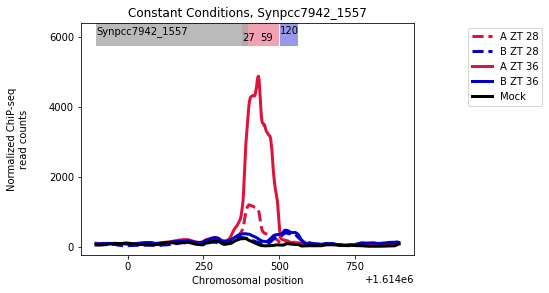

In [13]:
#circ_counts plots RpaA and RpaB ChIP data from 28 hours in constant light (ZT 28) and 36 hours in constant light (ZT 36)
#alongside a mock chip-seq experiment. The chromosomal location of the gene of interest is plotted as a gray rectangle
#The positions of all peaks within a 1000 base pair window from the gene start from the circadian experiment, 
#as determined by gene_window are plotted as red boxes for RpaA, and blue boxes for RpaB, with the number of the peak
#overlaid on the box. This function allows visualization of the results of ChIP-seq peak finding algorithms to compare
#true chip-seq data to the mock experiment to assess validity of the called peaks. Further, it demonstrates the spatial
#distribution of RpaA and RpaB peaks to allow analysis of their potential interaction at promoters.
circ_counts()

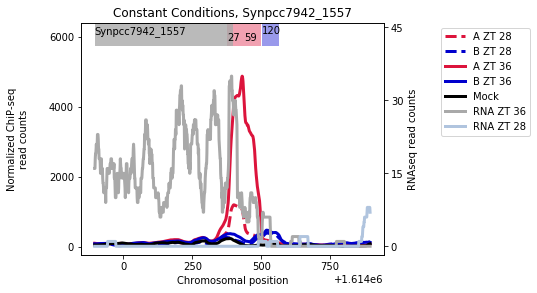

In [14]:
#circ_rna_counts plots RpaA and RpaB ChIP data from the circadian experiment just as in  circ_counts, but 
#this function adds RNAseq data from 28 and 36 hours in constant light onto the plot, corresponding to the right y-axis.
#The function determines the appropriate strand of the gene of interest from gene_window and only plots
#RNAseq data from the strand of the gene of interest. This allows visualization of the approximate transcription
#start site of the gene to analyze how RpaA and RpaB binding relates to the position of the transcription start site.
circ_rna_counts()

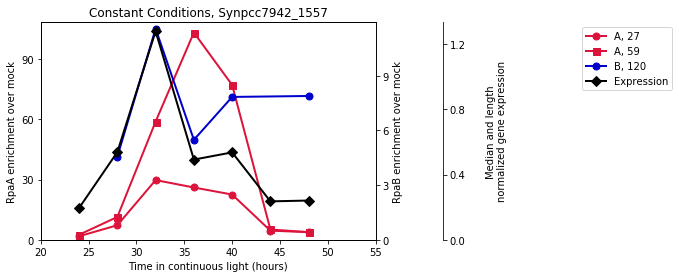

In [15]:
#circ_plot visualizes how gene expression of the gene of interest from gene_window changes under constant conditions
#and simultaneously plots how enrichment of RpaA and RpaB changes at peaks nearby the gene of interest as determined by
#gene_window. RpaA enrichment is plotted in red on the left y-axis, RpaB enrichment is plotted in blue on the first 
#right y-axis, and gene expression of the gene of interest is plotted in black on the right-most y-axis.
#By comparing with spatial information from circ_counts and circ_rna_counts, this function reveals temporal trends of gene expression
#and transcription binding to allow the formation of regulatory hypotheses. 
circ_plot()

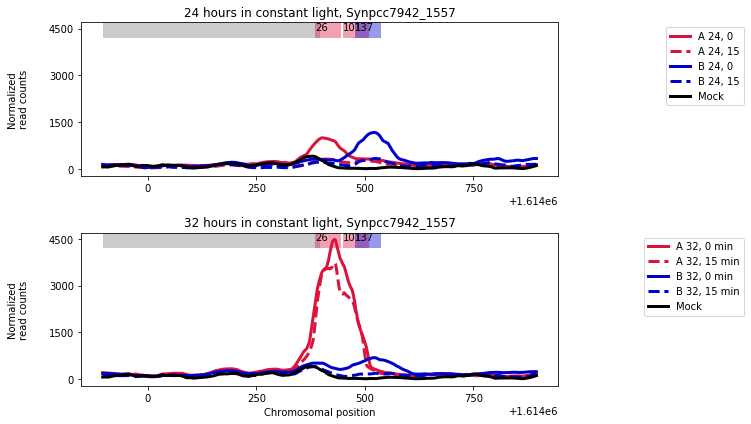

In [16]:
#high_light_counts plots RpaA and RpaB ChIP data from 24 hours in constant light (top plot) 
#and 32 hours in constant light (bottom plot) before and after exposure to high light intensity for 15 minutes,
#alongside a mock chip-seq experiment. The chromosomal location of the gene of interest is plotted as a gray rectangle
#The positions of all peaks within a 1000 base pair window from the gene start from the circadian experiment, 
#as determined by gene_window are plotted as red boxes for RpaA, and blue boxes for RpaB, with the number of the peak
#overlaid on the box. ChIP data is labelled as '0' in solid lines for before high light, and 
#'15' in dashed lines for 15 minutes in high light.
#This function allows visualization of the results of ChIP-seq peak finding algorithms to compare
#true chip-seq data to the mock experiment to assess validity of the called peaks. Further, it demonstrates the spatial
#distribution of RpaA and RpaB peaks to allow analysis of their potential interaction at promoters.
#The plots also reveal how binding changes over constant light (comparing solid lines from top and bottom plots)
#and how binding changes after exposure to high light (comparing solid and dashed lines within each plot).
high_light_counts()

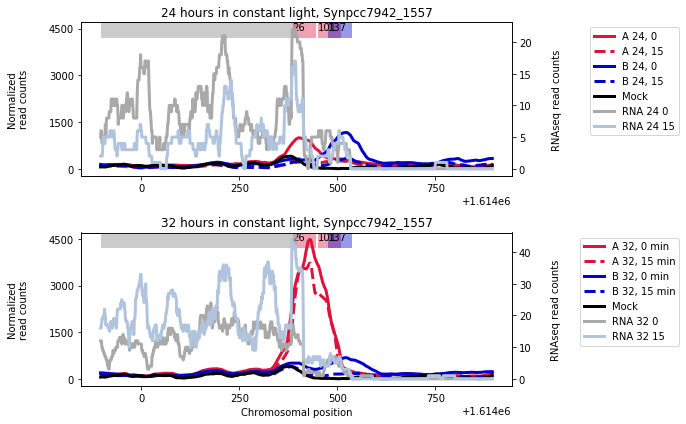

In [17]:
#high_light_rna_counts plots RpaA and RpaB ChIP data from the high light experiment just as in  high_light_counts, but 
#this function adds RNAseq data from the appropriate time points onto the plot, corresponding to the right y-axis.
#The function determines the appropriate strand of the gene of interest from gene_window and only plots
#RNAseq data from the strand of the gene of interest. This allows visualization of the approximate transcription
#start site of the gene to analyze how RpaA and RpaB binding relates to the position of the transcription start site.
high_light_rna_counts()

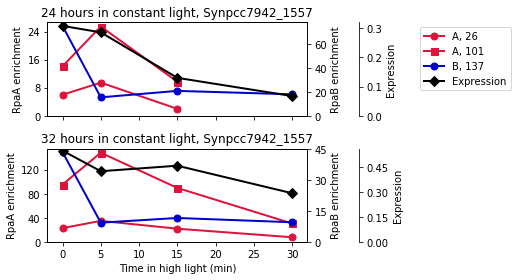

In [18]:
#hl_plot visualizes how gene expression of the gene of interest from gene_window changes after exposure to high light
#and simultaneously plots how enrichment of RpaA and RpaB changes at peaks nearby the gene of interest as determined by
#gene_window. RpaA enrichment is plotted in red on the left y-axis, RpaB enrichment is plotted in blue on the first 
#right y-axis, and gene expression of the gene of interest is plotted in black on the right-most y-axis. The top plot
#visualizes data from high light exposure at 24 hours in constant light, and the bottom does the same for 32 hours 
#in constant light. 
#By comparing with spatial information from high_light_counts and high_light_rna_counts, this function reveals temporal 
#trends of gene expression and transcription binding to allow the formation of regulatory hypotheses. 
hl_plot()

In [27]:
#a gene on the + strand with multiple overlapping RpaA and RpaB peaks
gene_window('Synpcc7942_0797')

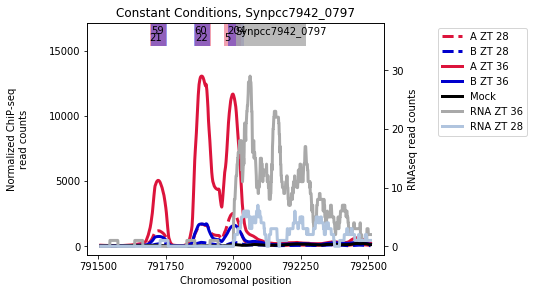

In [28]:
#overlapping RpaA/RpaB peaks appear purple
circ_rna_counts()

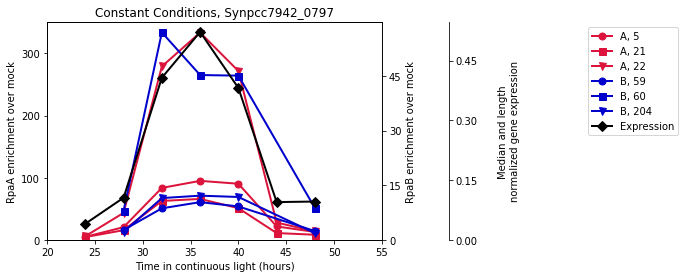

In [29]:
#binding of RpaA and RpaB strongly correlates with gene expression, changing in a coordinated way
circ_plot()

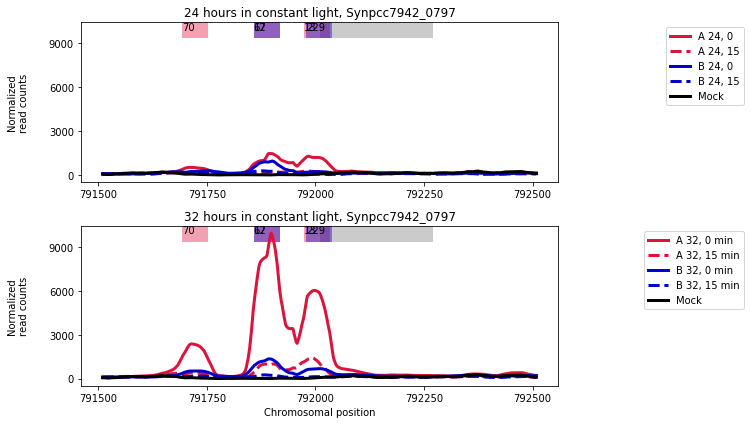

In [32]:
high_light_counts()

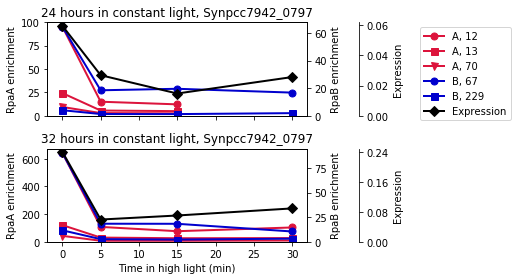

In [31]:
#binding of RpaA and RpaB decreases after high light, coincident with decrease in downstream gene expression
hl_plot()

In [33]:
#a gene on the + strand with many RpaA and RpaB peaks in the promoter
gene_window('Synpcc7942_0905')

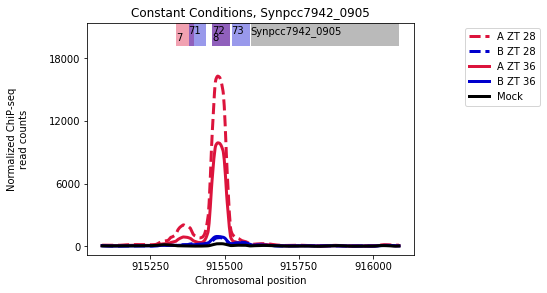

In [34]:
circ_counts()

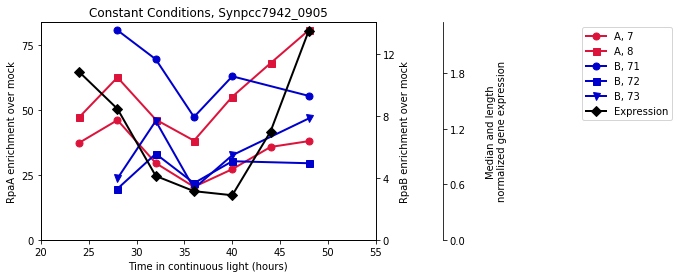

In [35]:
#complex dynamics of RpaA and RpaB binding roughly correlate with changes in gene expression
circ_plot()

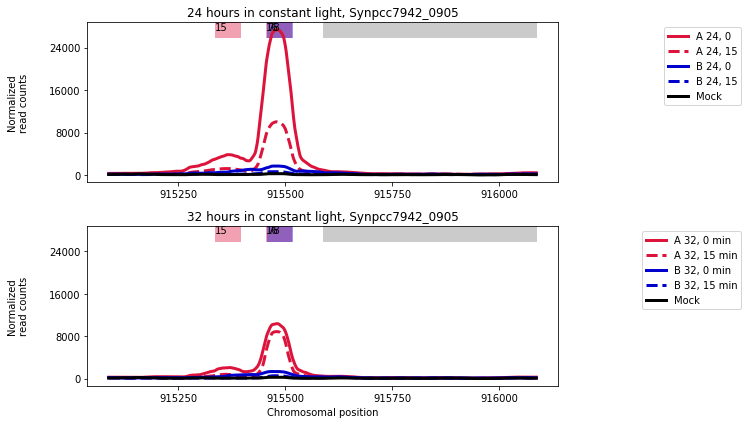

In [36]:
high_light_counts()

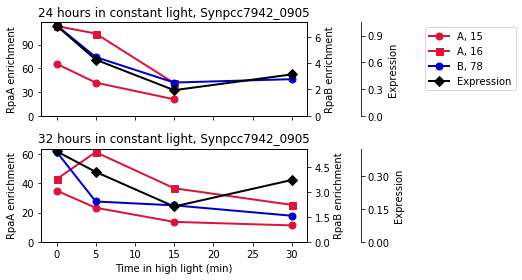

In [38]:
#RpaA and RpaB binding decreases after high light exposure, coincident with gene expression of nearby gene
hl_plot()